<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/main/ATE_Candy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import make_scorer, balanced_accuracy_score


from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut  , StratifiedKFold , cross_val_score , cross_val_predict
from scipy.stats import uniform , randint

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [60]:
data = pd.read_csv ("/content/candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [61]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [62]:
data.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent'],
      dtype='object')

In [63]:
c1 = data ['chocolate'] == 0
c2 = data ['fruity'] == 0
c  = c1 & c2

data ["other_candy"] = np.where (c , 1 , 0)

In [64]:
data ["winpercent"] = data ["winpercent"] / 100

In [65]:
decision_cols = ['chocolate', 'fruity', 'other_candy' ,'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']
cont_cols     = ['sugarpercent','winpercent' ,'pricepercent' ]

array([[<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'fruity'}>,
        <Axes: title={'center': 'other_candy'}>],
       [<Axes: title={'center': 'caramel'}>,
        <Axes: title={'center': 'peanutyalmondy'}>,
        <Axes: title={'center': 'nougat'}>],
       [<Axes: title={'center': 'crispedricewafer'}>,
        <Axes: title={'center': 'hard'}>,
        <Axes: title={'center': 'bar'}>],
       [<Axes: title={'center': 'pluribus'}>, <Axes: >, <Axes: >]],
      dtype=object)

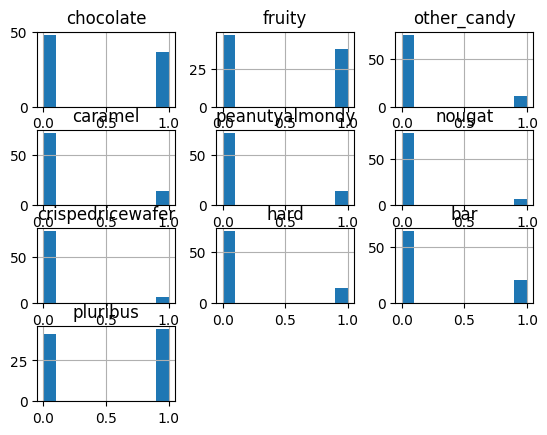

In [66]:
data [decision_cols].hist ()

In [67]:
data [decision_cols].nunique ()

chocolate           2
fruity              2
other_candy         2
caramel             2
peanutyalmondy      2
nougat              2
crispedricewafer    2
hard                2
bar                 2
pluribus            2
dtype: int64

In [68]:
#'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'pluribus'

df = data.copy (deep = True)

T = 'caramel'
W = 'winpercent'
X = [t for t in decision_cols if t not in [W , T , "bar"]]

df_Treatment_c = df [T] == 1
df_Control_c   = df [T] == 0
df_Treatment  = df [df_Treatment_c]
df_Control    = df [df_Control_c]

X_Treatment = pd.concat ( [df_Treatment [[T]],df_Treatment [X]] ,axis =1)
y_Treatment = df_Treatment [W]

X_Control  =  pd.concat ( [df_Control [[T]],df_Control [X]] ,axis =1)
y_Control  =  df_Control [W]

reg_Treatment        = RandomForestRegressor ()
reg_Control          = RandomForestRegressor ()

reg_Treatment.fit (X_Treatment,y_Treatment)
reg_Control.fit (X_Control,y_Control)

df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
df_Control   ["predictions"] = reg_Control.predict (X_Control)

ate   = df_Treatment ["predictions"].mean () - df_Control   ["predictions"].mean ()
ate

<ipython-input-68-a5b4a717073d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-68-a5b4a717073d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


0.08985201795340259

In [69]:
def get_ate_1 (data , T , W) :


    df = data.copy (deep = True)

    T = T
    W = W
    X = [t for t in decision_cols if t not in [W , T , "bar"]]

    df_Treatment_c = df [T] == 1
    df_Control_c   = df [T] == 0
    df_Treatment  = df [df_Treatment_c]
    df_Control    = df [df_Control_c]

    X_Treatment = pd.concat ( [df_Treatment [[T]],df_Treatment [X]] ,axis =1)
    y_Treatment = df_Treatment [W]

    X_Control  =  pd.concat ( [df_Control [[T]],df_Control [X]] ,axis =1)
    y_Control  =  df_Control [W]

    reg_Treatment        = RandomForestRegressor ()
    reg_Control          = RandomForestRegressor ()

    reg_Treatment.fit (X_Treatment,y_Treatment)
    reg_Control.fit (X_Control,y_Control)

    df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
    df_Control   ["predictions"] = reg_Control.predict (X_Control)

    ate   = df_Treatment ["predictions"].mean () - df_Control   ["predictions"].mean ()
    return ate

In [70]:
T = 'caramel'
W = 'winpercent'
get_ate_1 (data , T , W)

<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


0.08542045760240713

In [71]:
W_dict = {"winpercent" : [] , "pricepercent" :[] , "sugarpercent" :[]}
T_list = ['chocolate','caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'pluribus']

In [72]:
for W in W_dict.keys() :
    W_ate_list = []
    for T in T_list:
        ate = get_ate_1 (data , T , W)
        W_ate_list.append (ate)
        W_dict [W] = W_ate_list
        print (W,T,ate)

<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent chocolate 0.18720503586535447


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent caramel 0.08756021289505345


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent peanutyalmondy 0.1717956613017701


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent nougat 0.11073198030857939


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent crispedricewafer 0.18465396190608063


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent hard -0.1242704325860644


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent pluribus -0.06762880065632793


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent chocolate 0.2905801599271627


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent caramel 0.1982198310743717


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent peanutyalmondy 0.23263781876860773


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent nougat 0.15118415482792302


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent crispedricewafer 0.3528490227938825


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent hard -0.1748483802025404


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent pluribus -0.12899237429229493


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent chocolate 0.0584534608623441


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent caramel 0.2002391616881199


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent peanutyalmondy 0.0824151823299048


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent nougat 0.12718070281256422


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent crispedricewafer 0.031095841203224728


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


sugarpercent hard 0.08349962285153079
sugarpercent pluribus 0.024897629908272656


<ipython-input-69-903bf542fcf2>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-69-903bf542fcf2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


In [73]:
W_dict

{'winpercent': [0.18720503586535447,
  0.08756021289505345,
  0.1717956613017701,
  0.11073198030857939,
  0.18465396190608063,
  -0.1242704325860644,
  -0.06762880065632793],
 'pricepercent': [0.2905801599271627,
  0.1982198310743717,
  0.23263781876860773,
  0.15118415482792302,
  0.3528490227938825,
  -0.1748483802025404,
  -0.12899237429229493],
 'sugarpercent': [0.0584534608623441,
  0.2002391616881199,
  0.0824151823299048,
  0.12718070281256422,
  0.031095841203224728,
  0.08349962285153079,
  0.024897629908272656]}

In [74]:
pd.DataFrame (W_dict)

,winpercent,pricepercent,sugarpercent
0,0.187205,0.290580,0.058453
1,0.087560,0.198220,0.200239
2,0.171796,0.232638,0.082415
3,0.110732,0.151184,0.127181
4,0.184654,0.352849,0.031096
5,-0.124270,-0.174848,0.083500
6,-0.067629,-0.128992,0.024898


In [75]:
T_list

['chocolate',
 'caramel',
 'peanutyalmondy',
 'nougat',
 'crispedricewafer',
 'hard',
 'pluribus']

In [76]:
ate_df                = pd.DataFrame (W_dict)
ate_df ["treatments"] = T_list
ate_df.set_index ("treatments")

,winpercent,pricepercent,sugarpercent
treatments,,,
chocolate,0.187205,0.290580,0.058453
caramel,0.087560,0.198220,0.200239
peanutyalmondy,0.171796,0.232638,0.082415
nougat,0.110732,0.151184,0.127181
crispedricewafer,0.184654,0.352849,0.031096
hard,-0.124270,-0.174848,0.083500
pluribus,-0.067629,-0.128992,0.024898


In [77]:
#ate_df.to_csv ("ate_df.csv")

In [78]:
def get_ate_fruity (data , T , W) :


    df = data.copy (deep = True)

    T = T
    W = W
    X = [t for t in decision_cols if t not in [W , T , "chocolate" , "other_candy"]]

    df_Treatment_c = df [T] == 1
    df_Control_c   = df [T] == 0
    df_Treatment  = df [df_Treatment_c]
    df_Control    = df [df_Control_c]

    X_Treatment = pd.concat ( [df_Treatment [[T]],df_Treatment [X]] ,axis =1)
    y_Treatment = df_Treatment [W]

    X_Control  =  pd.concat ( [df_Control [[T]],df_Control [X]] ,axis =1)
    y_Control  =  df_Control [W]

    reg_Treatment        = RandomForestRegressor ()
    reg_Control          = RandomForestRegressor ()

    reg_Treatment.fit (X_Treatment,y_Treatment)
    reg_Control.fit (X_Control,y_Control)

    df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
    df_Control   ["predictions"] = reg_Control.predict (X_Control)

    ate   = df_Treatment ["predictions"].mean () - df_Control   ["predictions"].mean ()
    return ate

In [80]:
for W in W_dict.keys() :
    for T in ["fruity"]:
        ate = get_ate_fruity (data , T , W)
        W_dict [W].append (ate)
        print (W,T,ate)

<ipython-input-78-b5bda42a8276>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-78-b5bda42a8276>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent fruity -0.11257157567193826


<ipython-input-78-b5bda42a8276>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-78-b5bda42a8276>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent fruity -0.2442714692119431
sugarpercent fruity -0.012241969535750907


<ipython-input-78-b5bda42a8276>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-78-b5bda42a8276>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


In [81]:
def get_ate_other (data , T , W) :


    df = data.copy (deep = True)

    T = T
    W = W
    X = [t for t in decision_cols if t not in [W , T , "chocolate" , "fruity"]]

    df_Treatment_c = df [T] == 1
    df_Control_c   = df [T] == 0
    df_Treatment  = df [df_Treatment_c]
    df_Control    = df [df_Control_c]

    X_Treatment = pd.concat ( [df_Treatment [[T]],df_Treatment [X]] ,axis =1)
    y_Treatment = df_Treatment [W]

    X_Control  =  pd.concat ( [df_Control [[T]],df_Control [X]] ,axis =1)
    y_Control  =  df_Control [W]

    reg_Treatment        = RandomForestRegressor ()
    reg_Control          = RandomForestRegressor ()

    reg_Treatment.fit (X_Treatment,y_Treatment)
    reg_Control.fit (X_Control,y_Control)

    df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
    df_Control   ["predictions"] = reg_Control.predict (X_Control)

    ate   = df_Treatment ["predictions"].mean () - df_Control   ["predictions"].mean ()
    return ate

In [82]:
for W in W_dict.keys() :
    for T in ["other_candy"]:
        ate = get_ate_other (data , T , W)
        W_dict [W].append (ate)
        print (W,T,ate)

<ipython-input-81-187743091b87>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-81-187743091b87>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


winpercent other_candy -0.16197033881638367


<ipython-input-81-187743091b87>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-81-187743091b87>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


pricepercent other_candy -0.12438658822493298
sugarpercent other_candy -0.08891127205146904


<ipython-input-81-187743091b87>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Treatment ["predictions"] = reg_Treatment.predict (X_Treatment)
<ipython-input-81-187743091b87>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Control   ["predictions"] = reg_Control.predict (X_Control)


In [84]:
ate_df                = pd.DataFrame (W_dict)
ate_df ["treatments"] = ['chocolate',  'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'pluribus' , 'fruity', 'other_candy']
ate_df.set_index ("treatments")

,winpercent,pricepercent,sugarpercent
treatments,,,
chocolate,0.187205,0.290580,0.058453
caramel,0.087560,0.198220,0.200239
peanutyalmondy,0.171796,0.232638,0.082415
nougat,0.110732,0.151184,0.127181
crispedricewafer,0.184654,0.352849,0.031096
hard,-0.124270,-0.174848,0.083500
pluribus,-0.067629,-0.128992,0.024898
fruity,-0.112572,-0.244271,-0.012242
other_candy,-0.161970,-0.124387,-0.088911
